<a href="https://colab.research.google.com/github/napoles-uach/ML-FCQ/blob/main/GCN_grapheneEnergy_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 40.3 MB/s eta 0:00:00


In [2]:
#Instalar la libreria QLM
!pip3 install -q qml --user -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [1]:
#Si marca error, hay que reiniciar y ejecutar todo de nuevo
import qml

In [ ]:
#Cargar el archivo hojas-1-10000.tar.bz2

In [2]:
!tar -xf hojas-1-10000.tar.bz2

In [3]:
import os
import numpy as np
import dgl
from dgl.data import DGLDataset
import torch as th
import torch.nn as nn
import torch.nn.functional as F

xyz_dir = 'hojas-1-10000/'  # en esta carpeta van los archivos xyz
graphs = []
labels = []

file_count = 0
for file_name in [f for f in os.listdir(xyz_dir) if f.endswith('.xyz')]:
    if file_count >= 500:
        break

    file = xyz_dir + file_name
    mol = qml.Compound(xyz=file)
    nuclear=mol.nuclear_charges
    # Mapea las cargas a un indice para aumentar las features
    nuclear_to_atom_type_map = {6: 0, 7: 1, 5: -1}
    atom_type_values = np.array([nuclear_to_atom_type_map[nuclear_charge] for nuclear_charge in nuclear])

    with open(file) as f:
        n_atoms = int(f.readline().strip())


        header_info = f.readline().strip()
        energy, nC, nB, nN = header_info.split()[1:5]
        energy = float(energy[:-1])  

        coords = np.array([list(map(float, line.strip().split()[1:])) for line in f.readlines()])
        

        dist_mat = np.zeros((n_atoms, n_atoms))
        for i in range(n_atoms):
            for j in range(i + 1, n_atoms):
                dist = np.linalg.norm(coords[i] - coords[j])
                if dist<1.5:
                  dist_mat[i, j]=dist

        dist_mat += dist_mat.T - np.diag(dist_mat.diagonal())

        A = (dist_mat > 0).astype(int)
        u, v = np.nonzero(A)
        g = dgl.graph((u, v))
        g = dgl.add_self_loop(g)
        #feat = th.tensor(nuclear, dtype=th.float32)
        features = np.vstack((nuclear, atom_type_values)).T
        feat = th.tensor(features, dtype=th.float32)

        g.ndata['feat'] = feat
        graphs.append(g)

        labels.append(energy)  # Energia como target

    file_count += 1

labels = th.tensor(labels, dtype=th.float32)  # Convert labels to a PyTorch tensor
labels = th.abs(labels)
labels = (labels - th.mean(labels)) / th.std(labels)


#salvar a disco graphs y labels
th.save(graphs, 'graphs.pt')
th.save(labels, 'labels.pt')


       


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


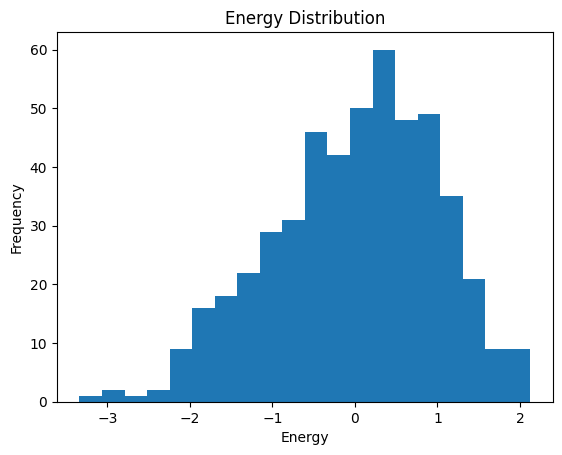

In [4]:
import matplotlib.pyplot as plt
#labels = th.load('labels.pt')
plt.hist(labels.numpy(), bins=20)
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Energy Distribution')
plt.show()


In [5]:
graphs = th.load('graphs.pt')
labels = th.load('labels.pt')

class SyntheticDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='synthetic')

    def process(self):
        self.graphs = graphs
        self.labels = labels

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

dataset = SyntheticDataset()

from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(dataset)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(th.arange(num_train))
test_sampler = SubsetRandomSampler(th.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=5, drop_last=False)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=5, drop_last=False)

from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
        #self.conv3 = GraphConv(h_feats, num_classes)
        self.fc = nn.Linear(num_classes, 1)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        #h = self.conv3(g,h)
        g.ndata['h'] = h
        h_g = dgl.mean_nodes(g, 'h')
        out = self.fc(h_g)
        return out


model = GCN(2, 64, 32)
optimizer = th.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batched_graph, energy in train_dataloader:
        prediction = model(batched_graph, batched_graph.ndata['feat'])
        loss = criterion(prediction, energy.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_dataloader)}")


model.eval()
test_loss = 0
with th.no_grad():
    for batched_graph, energy in test_dataloader:
        prediction = model(batched_graph, batched_graph.ndata['feat'])
        loss = criterion(prediction, energy.unsqueeze(1))
        test_loss += loss.item()
print(f"Test Loss: {test_loss / len(test_dataloader)}")


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 1, Loss: 1.0566432083025574
Epoch 2, Loss: 0.9973901867866516
Epoch 3, Loss: 1.008057512436062
Epoch 4, Loss: 1.0028240049257875
Epoch 5, Loss: 0.9946156971156597
Epoch 6, Loss: 1.01348920147866
Epoch 7, Loss: 0.9979869408532978
Epoch 8, Loss: 1.0005587263032794
Epoch 9, Loss: 0.9915552598424255
Epoch 10, Loss: 0.9949602942913771
Epoch 11, Loss: 0.9934806391596794
Epoch 12, Loss: 0.9833154559135437
Epoch 13, Loss: 0.9820477914065122
Epoch 14, Loss: 0.9652794048190116
Epoch 15, Loss: 0.9834737228229642
Epoch 16, Loss: 0.9623778715729714
Epoch 17, Loss: 0.9483274823054672
Epoch 18, Loss: 0.9506944479420781
Epoch 19, Loss: 0.928311129938811
Epoch 20, Loss: 0.9205878058448433
Epoch 21, Loss: 0.8938084714114666
Epoch 22, Loss: 0.8669545539654792
Epoch 23, Loss: 0.854892105422914
Epoch 24, Loss: 0.8022136432118714
Epoch 25, Loss: 0.7571085523813963
Epoch 26, Loss: 0.7717829741537571
Epoch 27, Loss: 0.656166186183691
Epoch 28, Loss: 0.6129846001043916
Epoch 29, Loss: 0.5151094773784279


Test Loss: 0.039010955346748234


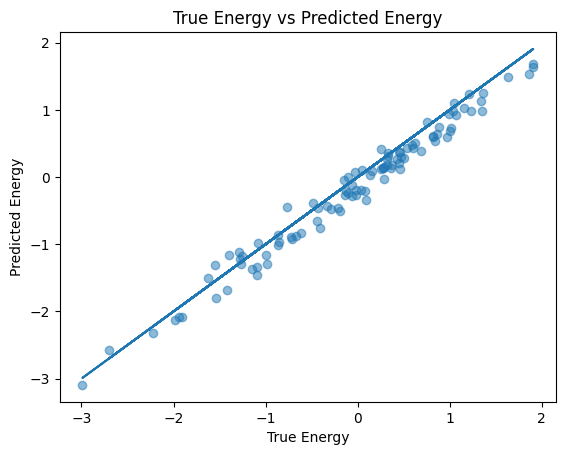

In [6]:
import matplotlib.pyplot as plt


model.eval()
test_loss = 0
true_energies = []
predicted_energies = []
with th.no_grad():
    for batched_graph, energy in test_dataloader:
        prediction = model(batched_graph, batched_graph.ndata['feat'])
        loss = criterion(prediction, energy.unsqueeze(1))
        test_loss += loss.item()

        true_energies.extend(energy.tolist())
        predicted_energies.extend(prediction.squeeze().tolist())

print(f"Test Loss: {test_loss / len(test_dataloader)}")

plt.scatter(true_energies, predicted_energies, alpha=0.5)
plt.plot(true_energies,true_energies)
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
plt.title('True Energy vs Predicted Energy')
plt.show()
